In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "2" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')

In [4]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)

br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']
progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [5]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]
    


ep=311
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    
ncluster=8
plotsavenameAdd='_plottingIdx_progBalanced_'+str(i)
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
    clusterRes=pickle.load(output)

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_

In [6]:
subclusternumbers=[4,6,8,6,6,6,6,4]
clusterRes_sub=np.zeros(clusterRes.size)-1
for i in np.unique(clusterRes):
    subcluster=subclusternumbers[i]
    subclustersavedir=os.path.join(clustersavedir,savenamecluster+'_subcluster'+str(i))

    savenameclustersub='minibatchkmean_ncluster'+str(subcluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
    with open(os.path.join(subclustersavedir,savenameclustersub), 'rb') as output:
        subclusterRes=pickle.load(output)
        
    clusterRes_sub[clusterRes==i]=subclusterRes

print(np.sum(clusterRes_sub==-1))

0


In [7]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)

In [8]:
#load NMCO
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

allstats=None
alllabels=None
alllabels_sub=None
allvarnames=None
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]

    path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'nmco_features',s.split('_')[-1] +'.csv')
    if not os.path.exists(path_s):
        print('DNE '+path_s)
    print(s)
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]
    assert np.min(plottingIdx_i_s)>=0

    stats_s=pd.read_csv(path_s)
    stats_s.index=stats_s.loc[:,'label']
    stats_s=stats_s.loc[cellIDlist[s][plottingIdx_i_s]].to_numpy()[:,2:-2]
    print(stats_s.shape)


#         ssplit=s.split('_')
    slabels=clusterRes[allImgNames[plottingIdx_i.astype(int)]==s]
    slabels_sub=clusterRes_sub[allImgNames[plottingIdx_i.astype(int)]==s]

    if allstats is None:
        allstats=stats_s
        alllabels=np.copy(slabels)
        alllabels_sub=np.copy(slabels_sub)
    else:
        allstats=np.concatenate((allstats,stats_s),axis=0)
        alllabels=np.concatenate((alllabels,np.copy(slabels)))
        alllabels_sub=np.concatenate((alllabels_sub,np.copy(slabels_sub)))


br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1
(380, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2
(508, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4
(360, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5
(358, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6
(525, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7
(314, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8
(862, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9
(484, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1
(2997, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10
(773, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2
(1286, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3
(1131, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4
(2694, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5
(954, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6
(780, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7
(667, 201)
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C8
(392, 201)
br1003a_1_cytokeratin_555_

(276, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F10
(312, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F2
(302, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F3
(227, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F4
(395, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F5
(169, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F6
(289, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F7
(308, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F8
(472, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F9
(358, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H1
(816, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H2
(3293, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H3
(2464, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H4
(1920, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H5
(1439, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H6
(2562, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H7
(1716, 201)
br8018a_1_cytokeratin_555_aSMA_647_hoechst_H8
(2838, 201)
br8018a_3_co

In [9]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=8000
model_str='fc3'

kernel_size=4
stride=2
padding=1

fc_dim1=128
fc_dim2=128
fc_dim3=128


dropout=0.01
kl_weight=0.0000001

name='exp0_clusterClf_nmco_subclusters_'+savenamecluster+'fcl3'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)


In [10]:
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainIdx.shape[0]/batchsize))):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        
#         trainInput=trainInputnp[trainIdx]
#         labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(stats_sub[trainIdx_i]).cuda().float()
            labels=torch.tensor(labels_sub[trainIdx_i]).cuda().long()
        optimizer.zero_grad()

        pred = model(trainInput)
#         print(trainInput)
#         print(pred)


        loss=lossCE(pred,labels)
        loss_all+=loss.item()
        
        loss.backward()
        optimizer.step()

    loss_all=loss_all/int(np.ceil(trainIdx.shape[0]/batchsize))
    
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            if use_cuda:
                valInput=torch.tensor(stats_sub[valIdx_i]).cuda().float()
                labels=torch.tensor(labels_sub[valIdx_i]).cuda().long()
                
            pred= model(valInput)

            loss_val=lossCE(pred,labels).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    if epoch%20==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all

Epoch: 0000 loss_train: 1.3693 loss_val: 1.3263
Epoch: 0020 loss_train: 0.1974 loss_val: 0.1396
Epoch: 0040 loss_train: 0.1425 loss_val: 0.1033
Epoch: 0060 loss_train: 0.1148 loss_val: 0.0888
Epoch: 0080 loss_train: 0.0978 loss_val: 0.0837
Epoch: 0100 loss_train: 0.0883 loss_val: 0.0781
Epoch: 0120 loss_train: 0.0758 loss_val: 0.0707
Epoch: 0140 loss_train: 0.0723 loss_val: 0.0695
Epoch: 0160 loss_train: 0.0682 loss_val: 0.0721
Epoch: 0180 loss_train: 0.0641 loss_val: 0.0715
Epoch: 0200 loss_train: 0.0602 loss_val: 0.0649
Epoch: 0220 loss_train: 0.0548 loss_val: 0.0685
Epoch: 0240 loss_train: 0.0554 loss_val: 0.0695
Epoch: 0260 loss_train: 0.0538 loss_val: 0.0751
Epoch: 0280 loss_train: 0.0483 loss_val: 0.0742
Epoch: 0300 loss_train: 0.0481 loss_val: 0.0784
Epoch: 0320 loss_train: 0.0468 loss_val: 0.0706
Epoch: 0340 loss_train: 0.0427 loss_val: 0.0785
Epoch: 0360 loss_train: 0.0416 loss_val: 0.0683
Epoch: 0380 loss_train: 0.0436 loss_val: 0.0863
Epoch: 0400 loss_train: 0.0375 loss_val:

Epoch: 3420 loss_train: 0.0097 loss_val: 0.1379
Epoch: 3440 loss_train: 0.0140 loss_val: 0.1417
Epoch: 3460 loss_train: 0.0131 loss_val: 0.1448
Epoch: 3480 loss_train: 0.0151 loss_val: 0.1199
Epoch: 3500 loss_train: 0.0137 loss_val: 0.1107
Epoch: 3520 loss_train: 0.0125 loss_val: 0.1451
Epoch: 3540 loss_train: 0.0160 loss_val: 0.1464
Epoch: 3560 loss_train: 0.0144 loss_val: 0.1257
Epoch: 3580 loss_train: 0.0142 loss_val: 0.1371
Epoch: 3600 loss_train: 0.0121 loss_val: 0.1229
Epoch: 3620 loss_train: 0.0129 loss_val: 0.1278
Epoch: 3640 loss_train: 0.0122 loss_val: 0.1349
Epoch: 3660 loss_train: 0.0152 loss_val: 0.1363
Epoch: 3680 loss_train: 0.0165 loss_val: 0.1158
Epoch: 3700 loss_train: 0.0137 loss_val: 0.1488
Epoch: 3720 loss_train: 0.0136 loss_val: 0.1290
Epoch: 3740 loss_train: 0.0174 loss_val: 0.1383
Epoch: 3760 loss_train: 0.0154 loss_val: 0.1264
Epoch: 3780 loss_train: 0.0140 loss_val: 0.1339
Epoch: 3800 loss_train: 0.0114 loss_val: 0.1327
Epoch: 3820 loss_train: 0.0138 loss_val:

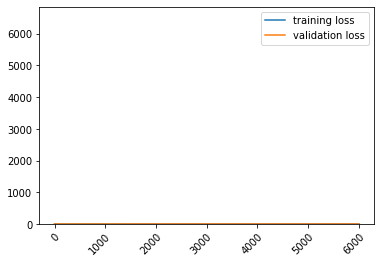

Epoch: 0000 loss_train: 1.7729 loss_val: 1.7163
Epoch: 0020 loss_train: 0.2814 loss_val: 0.1742
Epoch: 0040 loss_train: 0.1891 loss_val: 0.1213
Epoch: 0060 loss_train: 0.1482 loss_val: 0.1153
Epoch: 0080 loss_train: 0.1311 loss_val: 0.1145
Epoch: 0100 loss_train: 0.1200 loss_val: 0.1050
Epoch: 0120 loss_train: 0.1138 loss_val: 0.1009
Epoch: 0140 loss_train: 0.1062 loss_val: 0.0923
Epoch: 0160 loss_train: 0.1033 loss_val: 0.1151
Epoch: 0180 loss_train: 0.0953 loss_val: 0.1006
Epoch: 0200 loss_train: 0.0929 loss_val: 0.0979
Epoch: 0220 loss_train: 0.0891 loss_val: 0.0934
Epoch: 0240 loss_train: 0.0850 loss_val: 0.0914
Epoch: 0260 loss_train: 0.0867 loss_val: 0.0933
Epoch: 0280 loss_train: 0.0822 loss_val: 0.1211
Epoch: 0300 loss_train: 0.0811 loss_val: 0.0928
Epoch: 0320 loss_train: 0.0769 loss_val: 0.1021
Epoch: 0340 loss_train: 0.0755 loss_val: 0.1016
Epoch: 0360 loss_train: 0.0772 loss_val: 0.1001
Epoch: 0380 loss_train: 0.0732 loss_val: 0.0942
Epoch: 0400 loss_train: 0.0737 loss_val:

Epoch: 3420 loss_train: 0.0404 loss_val: 0.1098
Epoch: 3440 loss_train: 0.0399 loss_val: 0.1199
Epoch: 3460 loss_train: 0.0415 loss_val: 0.1309
Epoch: 3480 loss_train: 0.0415 loss_val: 0.1209
Epoch: 3500 loss_train: 0.0404 loss_val: 0.1347
Epoch: 3520 loss_train: 0.0414 loss_val: 0.1293
Epoch: 3540 loss_train: 0.0383 loss_val: 0.1301
Epoch: 3560 loss_train: 0.0441 loss_val: 0.1138
Epoch: 3580 loss_train: 0.0415 loss_val: 0.1399
Epoch: 3600 loss_train: 0.0448 loss_val: 0.1234
Epoch: 3620 loss_train: 0.0414 loss_val: 0.1243
Epoch: 3640 loss_train: 0.0386 loss_val: 0.1289
Epoch: 3660 loss_train: 0.0364 loss_val: 0.1244
Epoch: 3680 loss_train: 0.0378 loss_val: 0.1246
Epoch: 3700 loss_train: 0.0418 loss_val: 0.1242
Epoch: 3720 loss_train: 0.0383 loss_val: 0.1301
Epoch: 3740 loss_train: 0.0378 loss_val: 0.1397
Epoch: 3760 loss_train: 0.0394 loss_val: 0.1301
Epoch: 3780 loss_train: 0.0370 loss_val: 0.1262
Epoch: 3800 loss_train: 0.0414 loss_val: 0.1242
Epoch: 3820 loss_train: 0.0398 loss_val:

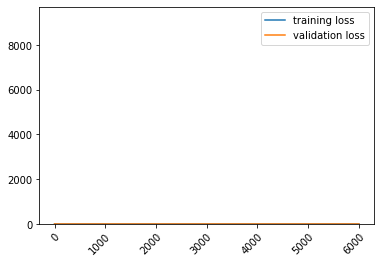

Epoch: 0000 loss_train: 2.0567 loss_val: 2.0180
Epoch: 0020 loss_train: 0.4670 loss_val: 0.2995
Epoch: 0040 loss_train: 0.3381 loss_val: 0.2266
Epoch: 0060 loss_train: 0.2964 loss_val: 0.2056
Epoch: 0080 loss_train: 0.2672 loss_val: 0.1931
Epoch: 0100 loss_train: 0.2469 loss_val: 0.1862
Epoch: 0120 loss_train: 0.2283 loss_val: 0.1806
Epoch: 0140 loss_train: 0.2173 loss_val: 0.1779
Epoch: 0160 loss_train: 0.2111 loss_val: 0.1734
Epoch: 0180 loss_train: 0.1998 loss_val: 0.1729
Epoch: 0200 loss_train: 0.1881 loss_val: 0.1685
Epoch: 0220 loss_train: 0.1847 loss_val: 0.1659
Epoch: 0240 loss_train: 0.1826 loss_val: 0.1688
Epoch: 0260 loss_train: 0.1745 loss_val: 0.1584
Epoch: 0280 loss_train: 0.1653 loss_val: 0.1606
Epoch: 0300 loss_train: 0.1664 loss_val: 0.1644
Epoch: 0320 loss_train: 0.1595 loss_val: 0.1659
Epoch: 0340 loss_train: 0.1610 loss_val: 0.1586
Epoch: 0360 loss_train: 0.1526 loss_val: 0.1564
Epoch: 0380 loss_train: 0.1483 loss_val: 0.1597
Epoch: 0400 loss_train: 0.1513 loss_val:

Epoch: 3420 loss_train: 0.0880 loss_val: 0.2291
Epoch: 3440 loss_train: 0.0842 loss_val: 0.2362
Epoch: 3460 loss_train: 0.0873 loss_val: 0.2361
Epoch: 3480 loss_train: 0.0875 loss_val: 0.2344
Epoch: 3500 loss_train: 0.0852 loss_val: 0.2272
Epoch: 3520 loss_train: 0.0909 loss_val: 0.2386
Epoch: 3540 loss_train: 0.0833 loss_val: 0.2338
Epoch: 3560 loss_train: 0.0890 loss_val: 0.2298
Epoch: 3580 loss_train: 0.0855 loss_val: 0.2364
Epoch: 3600 loss_train: 0.0839 loss_val: 0.2360
Epoch: 3620 loss_train: 0.0848 loss_val: 0.2271
Epoch: 3640 loss_train: 0.0816 loss_val: 0.2432
Epoch: 3660 loss_train: 0.0829 loss_val: 0.2353
Epoch: 3680 loss_train: 0.0871 loss_val: 0.2430
Epoch: 3700 loss_train: 0.0859 loss_val: 0.2427
Epoch: 3720 loss_train: 0.0862 loss_val: 0.2446
Epoch: 3740 loss_train: 0.0837 loss_val: 0.2370
Epoch: 3760 loss_train: 0.0850 loss_val: 0.2402
Epoch: 3780 loss_train: 0.0845 loss_val: 0.2425
Epoch: 3800 loss_train: 0.0840 loss_val: 0.2317
Epoch: 3820 loss_train: 0.0816 loss_val:

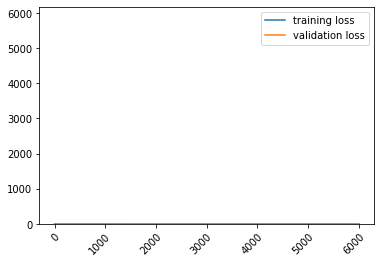

Epoch: 0000 loss_train: 1.7729 loss_val: 1.7302
Epoch: 0020 loss_train: 0.2743 loss_val: 0.1644
Epoch: 0040 loss_train: 0.1932 loss_val: 0.1349
Epoch: 0060 loss_train: 0.1638 loss_val: 0.1200
Epoch: 0080 loss_train: 0.1405 loss_val: 0.1085
Epoch: 0100 loss_train: 0.1261 loss_val: 0.1055
Epoch: 0120 loss_train: 0.1207 loss_val: 0.0998
Epoch: 0140 loss_train: 0.1096 loss_val: 0.0907
Epoch: 0160 loss_train: 0.1023 loss_val: 0.0956
Epoch: 0180 loss_train: 0.1017 loss_val: 0.0914
Epoch: 0200 loss_train: 0.0954 loss_val: 0.0917
Epoch: 0220 loss_train: 0.0885 loss_val: 0.0837
Epoch: 0240 loss_train: 0.0834 loss_val: 0.0825
Epoch: 0260 loss_train: 0.0817 loss_val: 0.0819
Epoch: 0280 loss_train: 0.0814 loss_val: 0.0811
Epoch: 0300 loss_train: 0.0769 loss_val: 0.0855
Epoch: 0320 loss_train: 0.0766 loss_val: 0.0954
Epoch: 0340 loss_train: 0.0739 loss_val: 0.0898
Epoch: 0360 loss_train: 0.0701 loss_val: 0.0791
Epoch: 0380 loss_train: 0.0674 loss_val: 0.0780
Epoch: 0400 loss_train: 0.0674 loss_val:

Epoch: 3420 loss_train: 0.0315 loss_val: 0.0915
Epoch: 3440 loss_train: 0.0309 loss_val: 0.0993
Epoch: 3460 loss_train: 0.0345 loss_val: 0.0936
Epoch: 3480 loss_train: 0.0322 loss_val: 0.0995
Epoch: 3500 loss_train: 0.0303 loss_val: 0.0949
Epoch: 3520 loss_train: 0.0331 loss_val: 0.0858
Epoch: 3540 loss_train: 0.0303 loss_val: 0.0996
Epoch: 3560 loss_train: 0.0300 loss_val: 0.0945
Epoch: 3580 loss_train: 0.0332 loss_val: 0.1018
Epoch: 3600 loss_train: 0.0294 loss_val: 0.0972
Epoch: 3620 loss_train: 0.0348 loss_val: 0.0942
Epoch: 3640 loss_train: 0.0286 loss_val: 0.1042
Epoch: 3660 loss_train: 0.0273 loss_val: 0.0912
Epoch: 3680 loss_train: 0.0339 loss_val: 0.0993
Epoch: 3700 loss_train: 0.0305 loss_val: 0.0800
Epoch: 3720 loss_train: 0.0329 loss_val: 0.0794
Epoch: 3740 loss_train: 0.0326 loss_val: 0.0872
Epoch: 3760 loss_train: 0.0310 loss_val: 0.0989
Epoch: 3780 loss_train: 0.0263 loss_val: 0.1110
Epoch: 3800 loss_train: 0.0289 loss_val: 0.0966
Epoch: 3820 loss_train: 0.0281 loss_val:

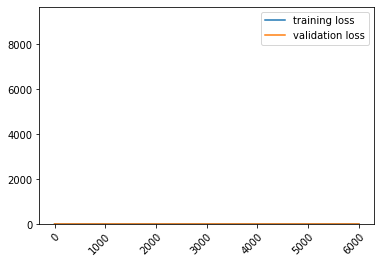

Epoch: 0000 loss_train: 1.7742 loss_val: 1.7299
Epoch: 0020 loss_train: 0.3806 loss_val: 0.2448
Epoch: 0040 loss_train: 0.2531 loss_val: 0.1855
Epoch: 0060 loss_train: 0.2132 loss_val: 0.1702
Epoch: 0080 loss_train: 0.1855 loss_val: 0.1643
Epoch: 0100 loss_train: 0.1620 loss_val: 0.1546
Epoch: 0120 loss_train: 0.1498 loss_val: 0.1482
Epoch: 0140 loss_train: 0.1380 loss_val: 0.1497
Epoch: 0160 loss_train: 0.1273 loss_val: 0.1432
Epoch: 0180 loss_train: 0.1252 loss_val: 0.1442
Epoch: 0200 loss_train: 0.1146 loss_val: 0.1453
Epoch: 0220 loss_train: 0.1098 loss_val: 0.1455
Epoch: 0240 loss_train: 0.1039 loss_val: 0.1347
Epoch: 0260 loss_train: 0.0999 loss_val: 0.1300
Epoch: 0280 loss_train: 0.0973 loss_val: 0.1410
Epoch: 0300 loss_train: 0.0963 loss_val: 0.1368
Epoch: 0320 loss_train: 0.0855 loss_val: 0.1275
Epoch: 0340 loss_train: 0.0854 loss_val: 0.1405
Epoch: 0360 loss_train: 0.0808 loss_val: 0.1371
Epoch: 0380 loss_train: 0.0808 loss_val: 0.1442
Epoch: 0400 loss_train: 0.0795 loss_val:

Epoch: 3420 loss_train: 0.0290 loss_val: 0.2407
Epoch: 3440 loss_train: 0.0316 loss_val: 0.2205
Epoch: 3460 loss_train: 0.0349 loss_val: 0.2237
Epoch: 3480 loss_train: 0.0317 loss_val: 0.2168
Epoch: 3500 loss_train: 0.0373 loss_val: 0.2417
Epoch: 3520 loss_train: 0.0311 loss_val: 0.2309
Epoch: 3540 loss_train: 0.0333 loss_val: 0.2304
Epoch: 3560 loss_train: 0.0368 loss_val: 0.2366
Epoch: 3580 loss_train: 0.0293 loss_val: 0.2284
Epoch: 3600 loss_train: 0.0318 loss_val: 0.2578
Epoch: 3620 loss_train: 0.0311 loss_val: 0.2122
Epoch: 3640 loss_train: 0.0337 loss_val: 0.2399
Epoch: 3660 loss_train: 0.0423 loss_val: 0.2365
Epoch: 3680 loss_train: 0.0337 loss_val: 0.2158
Epoch: 3700 loss_train: 0.0319 loss_val: 0.2162
Epoch: 3720 loss_train: 0.0299 loss_val: 0.2443
Epoch: 3740 loss_train: 0.0316 loss_val: 0.2463
Epoch: 3760 loss_train: 0.0288 loss_val: 0.2691
Epoch: 3780 loss_train: 0.0335 loss_val: 0.2441
Epoch: 3800 loss_train: 0.0318 loss_val: 0.2380
Epoch: 3820 loss_train: 0.0307 loss_val:

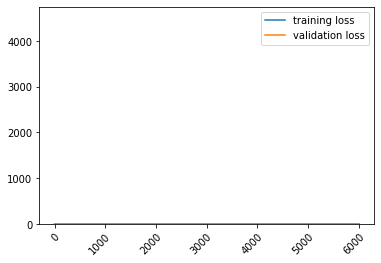

Epoch: 0000 loss_train: 1.7637 loss_val: 1.6991
Epoch: 0020 loss_train: 0.2891 loss_val: 0.1999
Epoch: 0040 loss_train: 0.1950 loss_val: 0.1400
Epoch: 0060 loss_train: 0.1648 loss_val: 0.1252
Epoch: 0080 loss_train: 0.1437 loss_val: 0.1168
Epoch: 0100 loss_train: 0.1313 loss_val: 0.1120
Epoch: 0120 loss_train: 0.1238 loss_val: 0.1104
Epoch: 0140 loss_train: 0.1122 loss_val: 0.1040
Epoch: 0160 loss_train: 0.1074 loss_val: 0.1049
Epoch: 0180 loss_train: 0.1018 loss_val: 0.1064
Epoch: 0200 loss_train: 0.0987 loss_val: 0.1046
Epoch: 0220 loss_train: 0.0962 loss_val: 0.1043
Epoch: 0240 loss_train: 0.0922 loss_val: 0.1034
Epoch: 0260 loss_train: 0.0888 loss_val: 0.1058
Epoch: 0280 loss_train: 0.0870 loss_val: 0.1091
Epoch: 0300 loss_train: 0.0867 loss_val: 0.1051
Epoch: 0320 loss_train: 0.0816 loss_val: 0.1061
Epoch: 0340 loss_train: 0.0821 loss_val: 0.1104
Epoch: 0360 loss_train: 0.0806 loss_val: 0.1067
Epoch: 0380 loss_train: 0.0786 loss_val: 0.1097
Epoch: 0400 loss_train: 0.0765 loss_val:

Epoch: 3420 loss_train: 0.0403 loss_val: 0.1448
Epoch: 3440 loss_train: 0.0417 loss_val: 0.1470
Epoch: 3460 loss_train: 0.0393 loss_val: 0.1633
Epoch: 3480 loss_train: 0.0392 loss_val: 0.1422
Epoch: 3500 loss_train: 0.0410 loss_val: 0.1427
Epoch: 3520 loss_train: 0.0393 loss_val: 0.1487
Epoch: 3540 loss_train: 0.0392 loss_val: 0.1542
Epoch: 3560 loss_train: 0.0425 loss_val: 0.1578
Epoch: 3580 loss_train: 0.0401 loss_val: 0.1524
Epoch: 3600 loss_train: 0.0415 loss_val: 0.1538
Epoch: 3620 loss_train: 0.0417 loss_val: 0.1617
Epoch: 3640 loss_train: 0.0381 loss_val: 0.1524
Epoch: 3660 loss_train: 0.0424 loss_val: 0.1492
Epoch: 3680 loss_train: 0.0410 loss_val: 0.1464
Epoch: 3700 loss_train: 0.0407 loss_val: 0.1518
Epoch: 3720 loss_train: 0.0391 loss_val: 0.1491
Epoch: 3740 loss_train: 0.0380 loss_val: 0.1490
Epoch: 3760 loss_train: 0.0401 loss_val: 0.1583
Epoch: 3780 loss_train: 0.0421 loss_val: 0.1547
Epoch: 3800 loss_train: 0.0400 loss_val: 0.1473
Epoch: 3820 loss_train: 0.0404 loss_val:

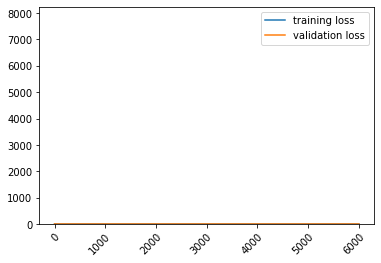

Epoch: 0000 loss_train: 1.7692 loss_val: 1.7021
Epoch: 0020 loss_train: 0.4579 loss_val: 0.3168
Epoch: 0040 loss_train: 0.3238 loss_val: 0.2409
Epoch: 0060 loss_train: 0.2641 loss_val: 0.2058
Epoch: 0080 loss_train: 0.2332 loss_val: 0.1980
Epoch: 0100 loss_train: 0.2096 loss_val: 0.1760
Epoch: 0120 loss_train: 0.1960 loss_val: 0.1716
Epoch: 0140 loss_train: 0.1824 loss_val: 0.1689
Epoch: 0160 loss_train: 0.1667 loss_val: 0.1593
Epoch: 0180 loss_train: 0.1598 loss_val: 0.1639
Epoch: 0200 loss_train: 0.1531 loss_val: 0.1584
Epoch: 0220 loss_train: 0.1413 loss_val: 0.1549
Epoch: 0240 loss_train: 0.1420 loss_val: 0.1528
Epoch: 0260 loss_train: 0.1359 loss_val: 0.1528
Epoch: 0280 loss_train: 0.1297 loss_val: 0.1597
Epoch: 0300 loss_train: 0.1254 loss_val: 0.1422
Epoch: 0320 loss_train: 0.1178 loss_val: 0.1499
Epoch: 0340 loss_train: 0.1151 loss_val: 0.1505
Epoch: 0360 loss_train: 0.1187 loss_val: 0.1607
Epoch: 0380 loss_train: 0.1164 loss_val: 0.1534
Epoch: 0400 loss_train: 0.1078 loss_val:

Epoch: 3420 loss_train: 0.0527 loss_val: 0.2411
Epoch: 3440 loss_train: 0.0548 loss_val: 0.2246
Epoch: 3460 loss_train: 0.0480 loss_val: 0.2444
Epoch: 3480 loss_train: 0.0499 loss_val: 0.2495
Epoch: 3500 loss_train: 0.0441 loss_val: 0.2451
Epoch: 3520 loss_train: 0.0498 loss_val: 0.2306
Epoch: 3540 loss_train: 0.0508 loss_val: 0.2583
Epoch: 3560 loss_train: 0.0522 loss_val: 0.2328
Epoch: 3580 loss_train: 0.0506 loss_val: 0.2555
Epoch: 3600 loss_train: 0.0583 loss_val: 0.2301
Epoch: 3620 loss_train: 0.0524 loss_val: 0.2281
Epoch: 3640 loss_train: 0.0481 loss_val: 0.2379
Epoch: 3660 loss_train: 0.0472 loss_val: 0.2306
Epoch: 3680 loss_train: 0.0468 loss_val: 0.2210
Epoch: 3700 loss_train: 0.0572 loss_val: 0.2233
Epoch: 3720 loss_train: 0.0513 loss_val: 0.2160
Epoch: 3740 loss_train: 0.0517 loss_val: 0.2520
Epoch: 3760 loss_train: 0.0492 loss_val: 0.2539
Epoch: 3780 loss_train: 0.0485 loss_val: 0.2377
Epoch: 3800 loss_train: 0.0483 loss_val: 0.2384
Epoch: 3820 loss_train: 0.0433 loss_val:

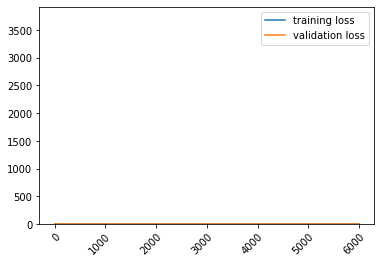

Epoch: 0000 loss_train: 1.3577 loss_val: 1.2953
Epoch: 0020 loss_train: 0.1556 loss_val: 0.1181
Epoch: 0040 loss_train: 0.1206 loss_val: 0.0977
Epoch: 0060 loss_train: 0.0990 loss_val: 0.0861
Epoch: 0080 loss_train: 0.0863 loss_val: 0.0817
Epoch: 0100 loss_train: 0.0816 loss_val: 0.0780
Epoch: 0120 loss_train: 0.0737 loss_val: 0.0731
Epoch: 0140 loss_train: 0.0717 loss_val: 0.0717
Epoch: 0160 loss_train: 0.0653 loss_val: 0.0710
Epoch: 0180 loss_train: 0.0629 loss_val: 0.0702
Epoch: 0200 loss_train: 0.0552 loss_val: 0.0708
Epoch: 0220 loss_train: 0.0542 loss_val: 0.0705
Epoch: 0240 loss_train: 0.0521 loss_val: 0.0687
Epoch: 0260 loss_train: 0.0505 loss_val: 0.0697
Epoch: 0280 loss_train: 0.0498 loss_val: 0.0695
Epoch: 0300 loss_train: 0.0463 loss_val: 0.0760
Epoch: 0320 loss_train: 0.0445 loss_val: 0.0784
Epoch: 0340 loss_train: 0.0465 loss_val: 0.0790
Epoch: 0360 loss_train: 0.0420 loss_val: 0.0646
Epoch: 0380 loss_train: 0.0446 loss_val: 0.0662
Epoch: 0400 loss_train: 0.0429 loss_val:

Epoch: 3420 loss_train: 0.0179 loss_val: 0.1562
Epoch: 3440 loss_train: 0.0178 loss_val: 0.1088
Epoch: 3460 loss_train: 0.0176 loss_val: 0.1561
Epoch: 3480 loss_train: 0.0163 loss_val: 0.1389
Epoch: 3500 loss_train: 0.0173 loss_val: 0.1372
Epoch: 3520 loss_train: 0.0175 loss_val: 0.1286
Epoch: 3540 loss_train: 0.0171 loss_val: 0.1266
Epoch: 3560 loss_train: 0.0160 loss_val: 0.1418
Epoch: 3580 loss_train: 0.0173 loss_val: 0.1370
Epoch: 3600 loss_train: 0.0171 loss_val: 0.1394
Epoch: 3620 loss_train: 0.0180 loss_val: 0.1605
Epoch: 3640 loss_train: 0.0158 loss_val: 0.1679
Epoch: 3660 loss_train: 0.0158 loss_val: 0.1464
Epoch: 3680 loss_train: 0.0162 loss_val: 0.1792
Epoch: 3700 loss_train: 0.0173 loss_val: 0.1426
Epoch: 3720 loss_train: 0.0163 loss_val: 0.1516
Epoch: 3740 loss_train: 0.0167 loss_val: 0.1597
Epoch: 3760 loss_train: 0.0166 loss_val: 0.1611
Epoch: 3780 loss_train: 0.0167 loss_val: 0.1687
Epoch: 3800 loss_train: 0.0172 loss_val: 0.1539
Epoch: 3820 loss_train: 0.0169 loss_val:

In [ ]:
pctVal=0.05
pctTest=0.1

allstats=allstats.astype(float)
allstats=scipy.stats.zscore(allstats,axis=0,nan_policy='omit')
allstats=np.nan_to_num(allstats,nan=0)

for i in np.unique(clusterRes):
    logsavepath_sub=os.path.join(logsavepath,str(i))
    plotsavepath_sub=os.path.join(plotsavepath,str(i))
    modelsavepath_sub=os.path.join(modelsavepath,str(i))
    if not os.path.exists(logsavepath_sub):
        os.mkdir(logsavepath_sub)
    if not os.path.exists(modelsavepath_sub):
        os.mkdir(modelsavepath_sub)
    if not os.path.exists(plotsavepath_sub):
        os.mkdir(plotsavepath_sub)
    
    stats_sub=allstats[alllabels==i]
    labels_sub=alllabels_sub[alllabels==i]
    
    #train-test split
    np.random.seed(3)
    allIdx=np.arange(stats_sub.shape[0])
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
    testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
    trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]
    
    trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
    fig, ax = plt.subplots()
    plt.bar(trainLabels,traincounts)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.savefig(os.path.join(plotsavepath_sub,'labelCounts.jpg'))
    
    weightClf=np.zeros(traincounts.size)
    for i in range(traincounts.size):
        weightClf[i]=np.sum(traincounts)/traincounts[i]/10
        
    # Create model
    seed=3
    torch.manual_seed(seed)
    nclasses=np.unique(labels_sub).size
    if use_cuda:
        torch.cuda.manual_seed(seed)

    if model_str=='fc3':
        model = modelsCNN.FC_l3(allstats.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
    if model_str=='fc5':
        model = modelsCNN.FC_l5(allstats.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
    if model_str=='fc1':
        model = modelsCNN.FC_l1(allstats.shape[1],fc_dim1,nclasses,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
    if model_str=='fc0':
        model = modelsCNN.FC_l0(allstats.shape[1],nclasses,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())

    if use_cuda:
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loss_ep=[None]*epochs
    val_loss_ep=[None]*epochs
    t_ep=time.time()

    for ep in range(epochs):
    # for ep in range(10000,20000):

        train_loss_ep[ep],val_loss_ep[ep]=train(ep)


        if ep%saveFreq == 0 and ep!=0:
            torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_sub,str(ep)+'.pt'))
        if use_cuda:
            model.cuda()
            torch.cuda.empty_cache()
    print(' total time: {:.4f}s'.format(time.time() - t_ep))
    with open(os.path.join(logsavepath_sub,'train_loss'), 'wb') as output:
        pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath_sub,'val_loss'), 'wb') as output:
        pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)

    plt.plot(np.arange(epochs),train_loss_ep)
    plt.plot(np.arange(epochs),val_loss_ep)
    plt.legend(['training loss','validation loss'],loc='upper right')
    plt.savefig(os.path.join(plotsavepath_sub,'loss_seed3.jpg'))
    plt.show()



In [17]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary')
    fig.colorbar(im)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(np.unique(ctlist).size))
    ax.set_xticklabels(np.unique(ctlist))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [20]:
#test loss
ep=5800

for i in np.unique(clusterRes):
    print(i)
    logsavepath_sub=os.path.join(logsavepath,str(i))
    plotsavepath_sub=os.path.join(plotsavepath,str(i))
    modelsavepath_sub=os.path.join(modelsavepath,str(i))
    
    stats_sub=allstats[alllabels==i]
    labels_sub=alllabels_sub[alllabels==i]
    
    #train-test split
    np.random.seed(3)
    allIdx=np.arange(stats_sub.shape[0])
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
    testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
    trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]
    
    trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
    weightClf=np.zeros(traincounts.size)
    for i in range(traincounts.size):
        weightClf[i]=np.sum(traincounts)/traincounts[i]/10
        
    
    # Create model
    seed=3
    torch.manual_seed(seed)
    nclasses=np.unique(labels_sub).size
    if use_cuda:
        torch.cuda.manual_seed(seed)

    if model_str=='fc3':
        model = modelsCNN.FC_l3(allstats.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
    if model_str=='fc5':
        model = modelsCNN.FC_l5(allstats.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
    if model_str=='fc1':
        model = modelsCNN.FC_l1(allstats.shape[1],fc_dim1,nclasses,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
    if model_str=='fc0':
        model = modelsCNN.FC_l0(allstats.shape[1],nclasses,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())

    if use_cuda:
        model.cuda()
        
    model.load_state_dict(torch.load(os.path.join(modelsavepath_sub,str(ep)+'.pt')))
    predtest=np.array([])
    with torch.no_grad():
        model.cuda()
        model.eval()
        loss_test_all=0
        ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
        for i in range(ntestBatches):
            testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
            testInput=torch.tensor(stats_sub[testIdx_i])
            if use_cuda:
                testInput=testInput.cuda().float()
                labels=torch.tensor(labels_sub[testIdx_i]).cuda().long()
            pred = model(testInput)
            predtest=np.concatenate((predtest,np.argmax(pred.cpu().detach().numpy(),axis=1)))

            loss_test=lossCE(pred,labels).item()

            loss_test_all+=loss_test

        loss_test_all=loss_test_all/ntestBatches

    print('test loss: '+str(loss_test_all))
    
    plotCTcomp(labels_sub[testIdx],predtest,plotsavepath_sub,'confusion_test',False)
    
    predtrain=np.array([])
    with torch.no_grad():
        model.cuda()
        model.eval()
        loss_train_all=0
        ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
        for i in range(ntrainBatches):
            trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
            trainInput=torch.tensor(stats_sub[trainIdx_i])
            if use_cuda:
                trainInput=trainInput.cuda().float()
                labels=torch.tensor(labels_sub[trainIdx_i]).cuda().long()
            pred = model(trainInput)
            predtrain=np.concatenate((predtrain,np.argmax(pred.cpu().detach().numpy(),axis=1)))

            loss_train=lossCE(pred,labels).item()

            loss_train_all+=loss_train

        loss_train_all=loss_train_all/ntrainBatches

    print('train loss: '+str(loss_train_all))
    plotCTcomp(labels_sub[trainIdx],predtrain,plotsavepath_sub,'confusion_train',False)

0
test loss: 0.18815137445926666
train loss: 0.0006257324324299892
1
test loss: 0.12270431220531464
train loss: 0.008571914921049029
2
test loss: 0.27827978134155273
train loss: 0.022929694736376405
3
test loss: 0.13980203866958618
train loss: 0.004088625207077712
4
test loss: 0.16260387003421783
train loss: 0.0024943791989547512
5
test loss: 0.13074420392513275
train loss: 0.006426195241510868
6
test loss: 0.28670138120651245
train loss: 0.007038193386203299
7
test loss: 0.1274639517068863
train loss: 0.0012648652860661968
